# 1. Business Understanding

Business Objective (BO):

Segment delivery orders to improve logistics efficiency and service prioritization.

Data Science Objective (DSO):

Use clustering on PCA-reduced features to identify meaningful groups of delivery orders.


# 2. Data Understanding


In [17]:

import pandas as pd

# Load dataset
df = pd.read_csv("datadelevry.csv")

print("Shape:", df.shape)
print("\nColonnes:", df.columns.tolist())

# Missing values
print("\nValeurs manquantes:")
print(df.isna().sum())

# Descriptive stats
print("\nStatistiques descriptives:")
print(df.describe())

# Example categorical distribution
print("\nStore categories (top 5):")
print(df["store_primary_category"].value_counts().head())


Shape: (172941, 14)

Colonnes: ['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']

Valeurs manquantes:
market_id                    4287
created_at                   3400
actual_delivery_time         3467
store_id                     3452
store_primary_category       7572
order_protocol               4310
total_items                  3488
subtotal                     3281
num_distinct_items           3452
min_item_price               3469
max_item_price               3420
total_onshift_partners      17328
total_busy_partners         17351
total_outstanding_orders    17317
dtype: int64

Statistiques descriptives:
           market_id  order_protocol    total_items       subtotal  \
count  168654.000000   168631.000000  169453.000000  169660.000000   
mean        2.982414 

# 3. Data Preparation


In [62]:

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Select features (mix of categorical & numerical)
features = [
    "market_id", "store_primary_category", "order_protocol",
    "total_items", "subtotal", "num_distinct_items",
    "min_item_price", "max_item_price",
    "total_onshift_partners", "total_busy_partners", "total_outstanding_orders"
]

X = df[features].copy()

# Frequency encoding for categorical variables
for col in ["market_id", "store_primary_category", "order_protocol"]:
    freqs = X[col].value_counts(normalize=True)
    X[col] = X[col].map(freqs)

# Imputation + scaling
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_scaled = scaler.fit_transform(imputer.fit_transform(X))
n, p = X_scaled.shape


# 4. Modeling


    Eigenvalue  Variance%  Cumulative%
0     3.220228   0.292748     0.292748
1     2.420487   0.220044     0.512792
2     1.781430   0.161948     0.674740
3     1.036884   0.094262     0.769003
4     0.877383   0.079762     0.848765
5     0.717836   0.065258     0.914023
6     0.371441   0.033767     0.947790
7     0.239048   0.021732     0.969521
8     0.171497   0.015591     0.985112
9     0.088534   0.008049     0.993161
10    0.075232   0.006839     1.000000


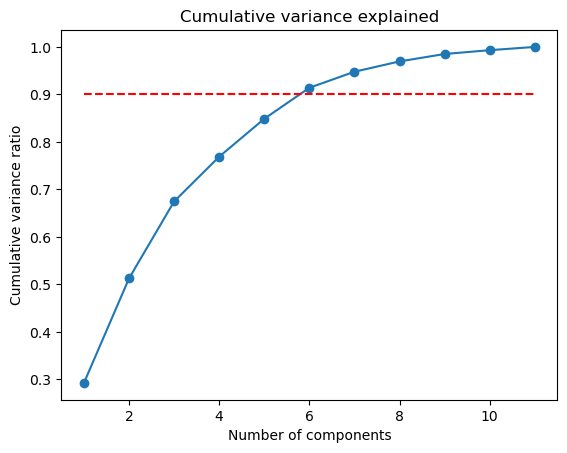

In [64]:

# 4a. PCA Analysis

from sklearn.decomposition import PCA

acp = PCA(svd_solver='full')
coord = acp.fit_transform(X_scaled)

eigval = acp.singular_values_**2 / n
variances = acp.explained_variance_ratio_

# Eigenvalues table
print(pd.DataFrame({"Eigenvalue": eigval, "Variance%": variances, "Cumulative%": np.cumsum(variances)}))

# Scree plot
plt.plot(range(1, p+1), np.cumsum(variances), marker="o")
plt.hlines(0.90, 1, p, colors="r", linestyles="--")
plt.title("Cumulative variance explained")
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance ratio")
plt.show()


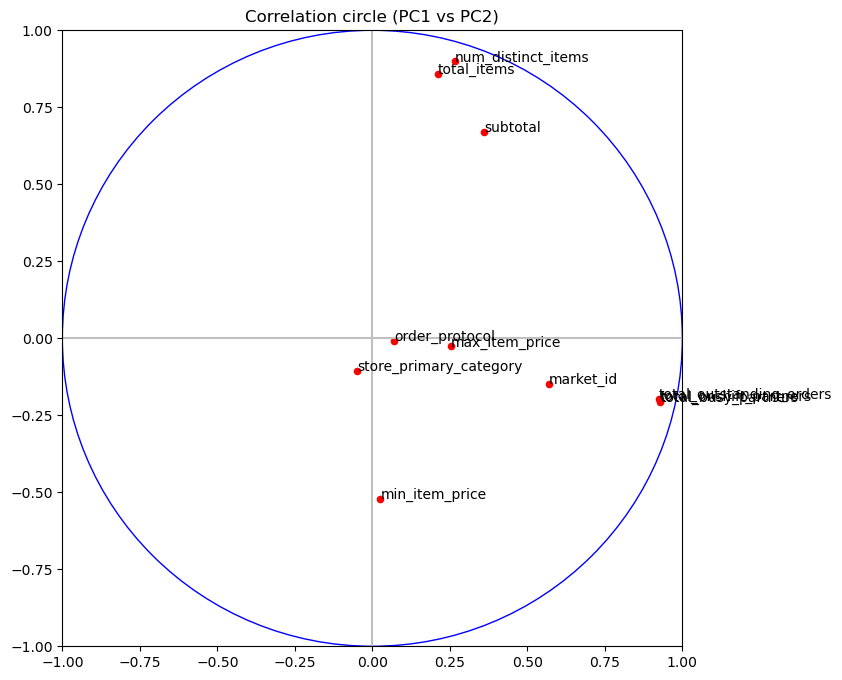

In [66]:
# 4b. PCA Correlation Circle

sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p, p))

for k in range(p):
    corvar[:, k] = acp.components_[k, :] * sqrt_eigval[k]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

# Circle
circle = plt.Circle((0,0), 1, color="blue", fill=False)
ax.add_artist(circle)
plt.axhline(0, color="silver")
plt.axvline(0, color="silver")

for j in range(p):
    plt.annotate(features[j], (corvar[j,0], corvar[j,1]))
    plt.scatter(corvar[j,0], corvar[j,1], color="red", s=20)

plt.title("Correlation circle (PC1 vs PC2)")
plt.show()


# Interpretation:
1. Correlation Circle (PC1 vs PC2)

PC1 (horizontal axis)
Strongly correlated with logistics features:

total_onshift_partners, total_busy_partners, total_outstanding_orders (all clustered on the right).
→ PC1 represents delivery ecosystem intensity.

PC2 (vertical axis)
Strongly correlated with order size features:

total_items, num_distinct_items, subtotal.
→ PC2 represents basket size & value.

min_item_price loads negatively on PC2 → identifies premium/high-unit-price orders.

In [29]:
# 4c. Variable Quality & Contribution

cos2var = corvar**2
ctrvar = cos2var.copy()

for k in range(p):
    ctrvar[:,k] = ctrvar[:,k] / eigval[k]

print(pd.DataFrame({
    "Variable": features,
    "COS2_PC1": cos2var[:,0],
    "COS2_PC2": cos2var[:,1],
    "CTR_PC1": ctrvar[:,0],
    "CTR_PC2": ctrvar[:,1]
}))


                    Variable  COS2_PC1  COS2_PC2   CTR_PC1   CTR_PC2
0                  market_id  0.325500  0.022269  0.101080  0.009200
1     store_primary_category  0.002436  0.011275  0.000757  0.004658
2             order_protocol  0.004876  0.000082  0.001514  0.000034
3                total_items  0.044635  0.737675  0.013861  0.304763
4                   subtotal  0.130201  0.446895  0.040432  0.184630
5         num_distinct_items  0.070777  0.807574  0.021979  0.333641
6             min_item_price  0.000671  0.271879  0.000208  0.112324
7             max_item_price  0.063676  0.000712  0.019774  0.000294
8     total_onshift_partners  0.861769  0.040791  0.267611  0.016853
9        total_busy_partners  0.862635  0.042459  0.267880  0.017542
10  total_outstanding_orders  0.853051  0.038876  0.264904  0.016061


# Interprtation:
2. Variable Quality (COS² & Contribution CTR)

From your table:

Best represented on PC1:

total_onshift_partners (COS²=0.86),

total_busy_partners (0.86),

total_outstanding_orders (0.85).
→ These dominate PC1.

Best represented on PC2:

num_distinct_items (0.81),

total_items (0.74),

subtotal (0.45),

min_item_price (0.27).
→ These dominate PC2.

Low contribution:
order_protocol, store_primary_category → not discriminant.

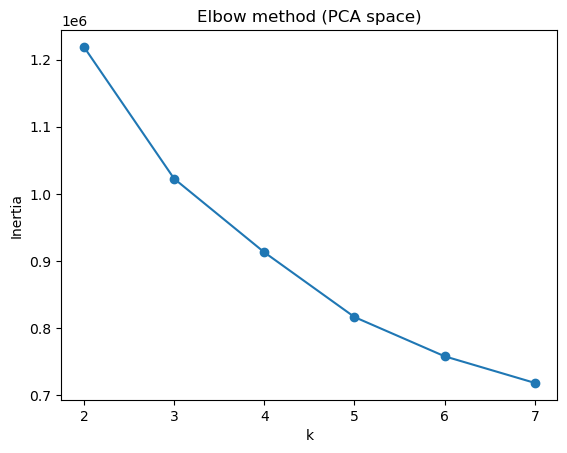

cluster
1    70733
3    39331
4    27111
2    20531
0    15235
Name: count, dtype: int64


In [31]:
# 4d. Clustering on PCA-reduced space

from sklearn.cluster import KMeans

# Use first 5 PCs (90%+ variance usually)
X_pca = coord[:, :5]

# Elbow method
inertias = []
K = range(2, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method (PCA space)")
plt.show()

# Final clustering (k=5 as example)
kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X_pca)

print(df["cluster"].value_counts())


# 5. Evaluation 


Numeric features used for profiling: ['market_id', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']
Cluster profiles:
          market_id  order_protocol  total_items     subtotal  \
cluster                                                        
0         3.007730        2.694129     1.776194  3351.454436   
1         2.948863        2.631827     2.480888  2035.136526   
2         2.987909        2.726254     7.489486  5760.030340   
3         2.883688        3.167964     2.970350  2643.513988   
4         3.193922        3.130611     2.946665  1714.945772   

         num_distinct_items  min_item_price  max_item_price  \
cluster                                                       
0                  1.630944     1680.851213     2120.427550   
1                  2.204622      631.505207     1023.254836   
2                  5.648459      408.932810     1

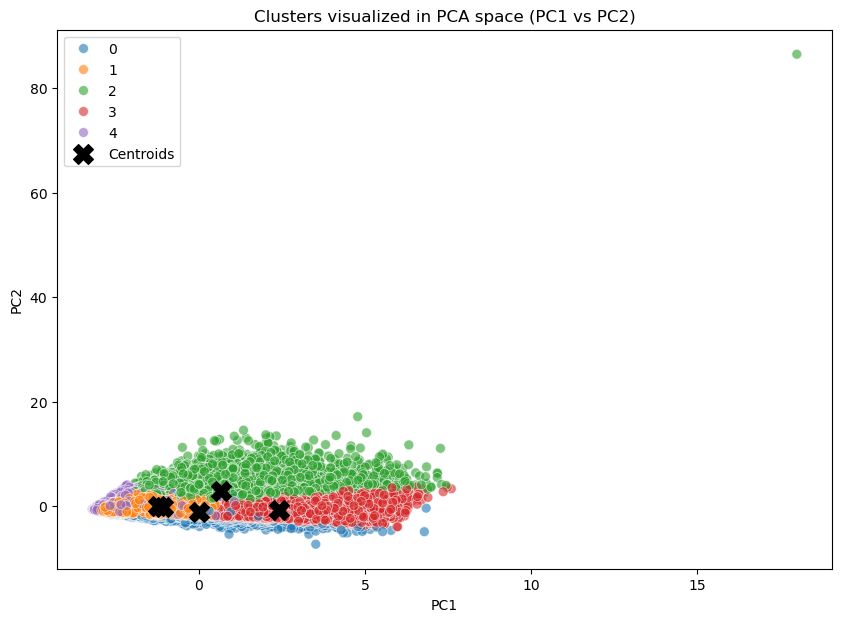

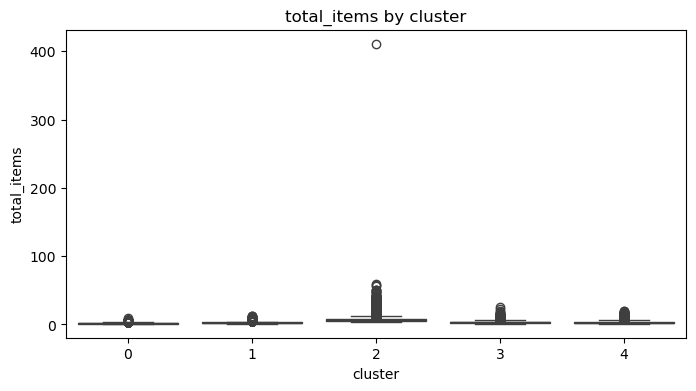

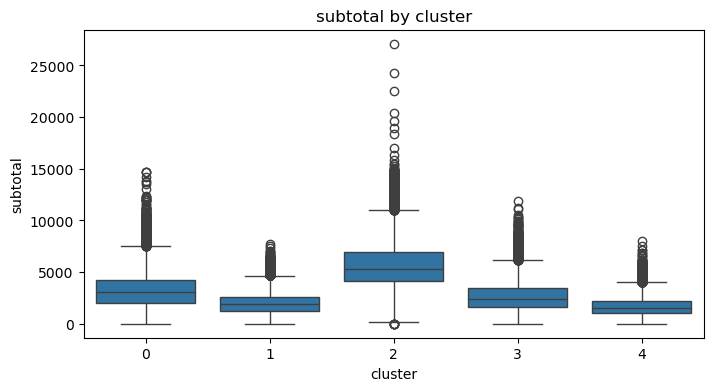

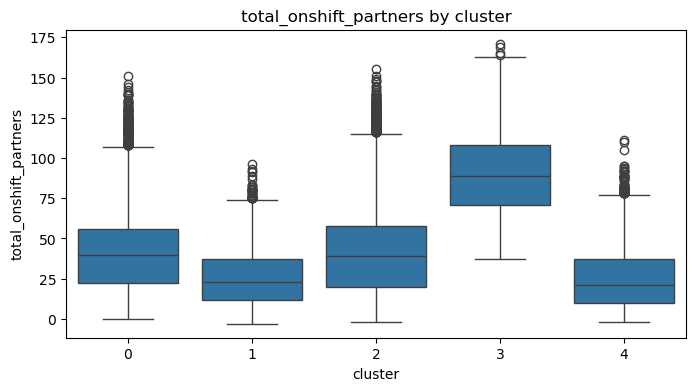

In [56]:

# Ensure only numeric columns are used in profiling
numeric_features = df[features].select_dtypes(include=[np.number]).columns.tolist()

print("Numeric features used for profiling:", numeric_features)

# Cluster profiles
cluster_profiles = df.groupby("cluster")[numeric_features].mean()
print("Cluster profiles:\n", cluster_profiles)

# Visualization (PCA 2D space)
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=coord[:,0], y=coord[:,1],
    hue=df["cluster"], palette="tab10",
    s=50, alpha=0.6
)

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0], centroids[:,1], c='black', s=200, marker='X', label='Centroids')

plt.title("Clusters visualized in PCA space (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


# Boxplot examples
for col in ["total_items", "subtotal", "total_onshift_partners"]:
    if col in numeric_features:  # only plot if numeric
        plt.figure(figsize=(8,4))
        sns.boxplot(x="cluster", y=col, data=df)
        plt.title(f"{col} by cluster")
        plt.show()


Cluster 0 → Premium niche customers
Small baskets but very high price/unit. Need priority delivery to maintain satisfaction.

Cluster 1 → Core low-cost demand
Largest customer base but least profitable per order. Focus on operational efficiency.

Cluster 2 → Bulk buyers
Large, heavy orders → need optimized delivery capacity (bigger vehicles, group planning).

Cluster 3 → Standard urban orders
Balanced orders with dense logistics availability. Potential for promotions / fast delivery promises.

Cluster 4 → Low-cost suburban orders
Smaller orders, cheap products, less delivery coverage. Might be less profitable.

# 6. Deployment (Business Insights)



Répartition par cluster (avec labels):
cluster_label
Commandes urbaines standard           70733
Commandes premium                     39331
Commandes standard en zones denses    27111
Gros paniers hors centre              20531
Petites commandes isolées             15235
Name: count, dtype: int64


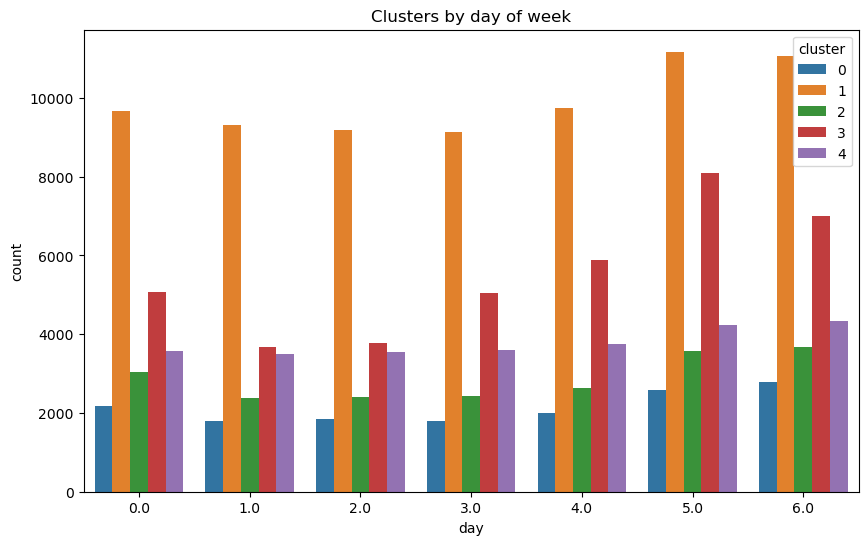

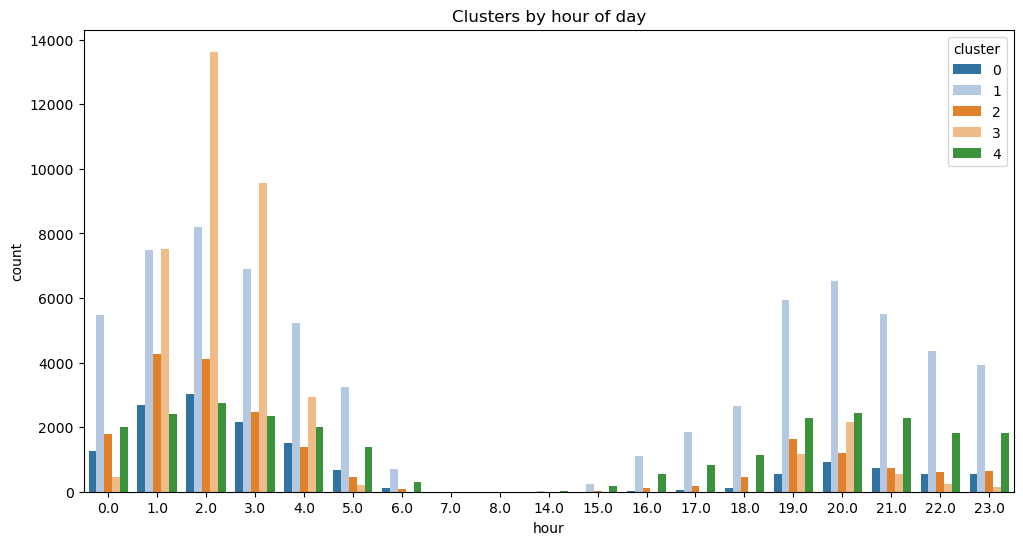

In [77]:

# Assign business labels (example)
cluster_labels = {
    0: "Petites commandes isolées",
    1: "Commandes urbaines standard",
    2: "Gros paniers hors centre",
    3: "Commandes premium",
    4: "Commandes standard en zones denses"
}
df["cluster_label"] = df["cluster"].map(cluster_labels)

print("\nRépartition par cluster (avec labels):")
print(df["cluster_label"].value_counts())

# Time patterns
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df["day"] = df["created_at"].dt.dayofweek
df["hour"] = df["created_at"].dt.hour

plt.figure(figsize=(10,6))
sns.countplot(x="day", hue="cluster", data=df, palette="tab10")
plt.title("Clusters by day of week")
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(x="hour", hue="cluster", data=df, palette="tab20")
plt.title("Clusters by hour of day")
plt.show()
